In [1]:
# Import packages
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import itertools
from matplotlib.cbook import _reshape_2D

Getting the climate sensitivity values for each model

In [2]:
climate_sensitives = {
    'ACCESS-CM2': 4.7,
    'ACCESS-ESM1-5': 3.9,
    'BCC-CSM2-MR': 3.0,
    'CAMS-CSM1-0': 2.3,
    'CESM2': 5.2,
    'CESM2-WACCM': 4.8,
    'CMCC-CM2-SR5': 3.52,
    'CMCC-ESM2': 3.57,
    'CanESM5': 5.6,
    'E3SM-1-1': np.nan,
    'EC-Earth3-Veg-LR': np.nan,
    'FGOALS-f3-L': 3.0,
    'FGOALS-g3': np.nan,
    'FIO-ESM-2-0': np.nan,
    'GFDL-CM4': 3.9,
    'GFDL-ESM4': 2.6,
    'IITM-ESM': np.nan,
    'INM-CM4-8': 1.8,
    'INM-CM5-0': 1.9,
    'IPSL-CM5A2-INCA': np.nan,
    'IPSL-CM6A-LR': 4.6,
    'KIOST-ESM': np.nan,
    'MIROC6': 2.6,
    'MPI-ESM1-2-HR': 3.0,
    'MPI-ESM1-2-LR': 3.0,
    'MRI-ESM2-0': 3.2,
    'NESM3': 4.7,
    'NorESM2-LM': 2.5,
    'NorESM2-MM': 2.5,
    'UKESM1-0-LL': 5.3
}
climate_sensitivies_df = pd.DataFrame(climate_sensitives.items(), columns = ['esm', 'climate_sensitivity'])

Getting the number of ensembles and different experiments available for each of the models

In [3]:
metrics_df = pd.read_csv('extracted_timeseries/extracted_metrics/IPCC_land_regions_metrics.csv')
my_combinations = metrics_df[['esm', 'experiment', 'ensemble']].drop_duplicates()
combinations_count = my_combinations.groupby(['esm', 'experiment']).count().reset_index()
combinations_count

,esm,experiment,ensemble
0,ACCESS-CM2,ssp126,5
1,ACCESS-CM2,ssp245,5
2,ACCESS-CM2,ssp370,5
3,ACCESS-CM2,ssp585,5
4,ACCESS-ESM1-5,ssp126,40
...,...,...,...
128,UKESM1-0-LL,ssp126,13
129,UKESM1-0-LL,ssp245,14
130,UKESM1-0-LL,ssp370,13
131,UKESM1-0-LL,ssp434,5


Defining a function to decide whether to include the model in the running. Has to have a certain set of experiments available, and a certain number of total ensemble runs.

In [4]:
def inclusion_criterion(df):
    contains_all = np.all(np.isin(['ssp126', 'ssp245', 'ssp370', 'ssp585'], df.experiment))
    many_runs = np.sum(df.ensemble) >= 4
    try:
        known_climate_sensitivity = ~np.isnan(climate_sensitives[df['esm'].values[0]])
    except KeyError:
        known_climate_sensitivity = False

    return contains_all & many_runs  & known_climate_sensitivity

These are the models which meet the criteria set in the above function

In [5]:
inclusion_df = combinations_count.groupby(['esm']).apply(inclusion_criterion)
inclusion_df = pd.DataFrame(inclusion_df).reset_index().rename(columns={0: 'include'})
inclusion_df[inclusion_df['include']]

,esm,include
0,ACCESS-CM2,True
1,ACCESS-ESM1-5,True
2,BCC-CSM2-MR,True
3,CAMS-CSM1-0,True
4,CESM2,True
5,CESM2-WACCM,True
7,CMCC-CM2-SR5,True
8,CMCC-ESM2,True
9,CanESM5,True
12,FGOALS-f3-L,True


In [6]:
len(inclusion_df[inclusion_df['include']]['esm'])

21

This is how the distribution of climate sensitivities changes when we only include models that meet the criteria

Text(313.39267676767673, 0.5, '')

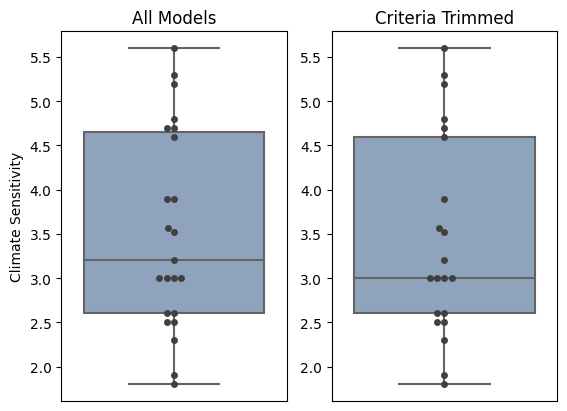

In [7]:
included_esms = inclusion_df[inclusion_df['include']]['esm'].values
included_cs_df = climate_sensitivies_df[np.isin(climate_sensitivies_df['esm'], included_esms)]

fig, (ax1,ax2) = plt.subplots(1,2)
sns.boxplot(ax = ax1, y='climate_sensitivity', data=climate_sensitivies_df, showfliers = False, color='#89a2c4')
sns.swarmplot(ax = ax1, y='climate_sensitivity', data=climate_sensitivies_df, color='0.25')
sns.boxplot(ax = ax2, y='climate_sensitivity', data=included_cs_df, showfliers = False, color='#89a2c4')
sns.swarmplot(ax = ax2, y='climate_sensitivity', data=included_cs_df, color='0.25')

ax1.set_title('All Models')
ax2.set_title('Criteria Trimmed')
ax1.tick_params(axis='x', bottom=False, top=False, which='both', labelbottom=False)
ax2.tick_params(axis='x', bottom=False, top=False, which='both', labelbottom=False)
ax1.set_ylabel('Climate Sensitivity')
ax2.set_ylabel('')


In [8]:
def cs_group(x):
    if (x < 2) or (x > 5):
        return 'unlikely'
    elif (x < 4) and (x > 2.5):
        return 'likely'

    return 'very likely'

In [9]:
included_cs_df['group'] = [cs_group(x) for x in included_cs_df.climate_sensitivity]
included_cs_df = included_cs_df.reset_index(drop=True)
included_cs_df

/var/folders/03/82f8dprj20zdn3zkgcd_p1280000gn/T/ipykernel_4619/448732164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  included_cs_df['group'] = [cs_group(x) for x in included_cs_df.climate_sensitivity]


,esm,climate_sensitivity,group
0,ACCESS-CM2,4.70,very likely
1,ACCESS-ESM1-5,3.90,likely
2,BCC-CSM2-MR,3.00,likely
3,CAMS-CSM1-0,2.30,very likely
4,CESM2,5.20,unlikely
5,CESM2-WACCM,4.80,very likely
6,CMCC-CM2-SR5,3.52,likely
7,CMCC-ESM2,3.57,likely
8,CanESM5,5.60,unlikely
9,FGOALS-f3-L,3.00,likely


In [10]:
[x for x in np.unique(np.array(included_cs_df.climate_sensitivity.values)) if (x < 4) and (x > 2.5)]

[2.6, 3.0, 3.2, 3.52, 3.57, 3.9]

In [11]:
included_cs_df[included_cs_df['group'] == 'likely'].index.values

array([ 1,  2,  6,  7,  9, 10, 14, 15, 16, 17])

In [12]:
from itertools import combinations

In [13]:
included_cs_df[included_cs_df['group'] == 'likely']

,esm,climate_sensitivity,group
1,ACCESS-ESM1-5,3.90,likely
2,BCC-CSM2-MR,3.00,likely
6,CMCC-CM2-SR5,3.52,likely
7,CMCC-ESM2,3.57,likely
9,FGOALS-f3-L,3.00,likely
10,GFDL-ESM4,2.60,likely
14,MIROC6,2.60,likely
15,MPI-ESM1-2-HR,3.00,likely
16,MPI-ESM1-2-LR,3.00,likely
17,MRI-ESM2-0,3.20,likely


In [14]:
likely_combs = list(combinations(included_cs_df[included_cs_df['group'] == 'likely'].index.values, 4))
df = pd.DataFrame(columns=['esm1', 'esm2', 'esm3', 'esm4', 'esm5', 'cs1', 'cs2', 'cs3', 'cs4', 'cs5'])
for comb in likely_combs:
    esm_sample = included_cs_df.iloc[np.array(comb)]
    sample_cs = np.array(esm_sample.climate_sensitivity.values)
    consecutive_diff = np.diff(np.sort(sample_cs))
    if ~np.isin(0, consecutive_diff) and np.isin(2.6, sample_cs) and np.isin(3.9, sample_cs):
        for ind in included_cs_df[included_cs_df['group'] == 'very likely'].index:
            vl_row = included_cs_df.iloc[ind]
            esms_sorted = np.sort(np.concatenate((np.array(esm_sample.esm.values), np.array(vl_row.esm).reshape(1))))
            sample_cs = [climate_sensitives[esms_sorted[j]] for j in range(len(esms_sorted))]
            new_row = np.concatenate((esms_sorted, np.array(sample_cs)))
            df = pd.concat([df, pd.DataFrame(new_row.reshape(1,-1), columns=list(df))], ignore_index=True)
df

,esm1,esm2,esm3,esm4,esm5,cs1,cs2,cs3,cs4,cs5
0,ACCESS-CM2,ACCESS-ESM1-5,BCC-CSM2-MR,CMCC-CM2-SR5,GFDL-ESM4,4.7,3.9,3.0,3.52,2.6
1,ACCESS-ESM1-5,BCC-CSM2-MR,CAMS-CSM1-0,CMCC-CM2-SR5,GFDL-ESM4,3.9,3.0,2.3,3.52,2.6
2,ACCESS-ESM1-5,BCC-CSM2-MR,CESM2-WACCM,CMCC-CM2-SR5,GFDL-ESM4,3.9,3.0,4.8,3.52,2.6
3,ACCESS-ESM1-5,BCC-CSM2-MR,CMCC-CM2-SR5,GFDL-ESM4,IPSL-CM6A-LR,3.9,3.0,3.52,2.6,4.6
4,ACCESS-ESM1-5,BCC-CSM2-MR,CMCC-CM2-SR5,GFDL-ESM4,NorESM2-LM,3.9,3.0,3.52,2.6,2.5
...,...,...,...,...,...,...,...,...,...,...
175,ACCESS-ESM1-5,CAMS-CSM1-0,MIROC6,MPI-ESM1-2-LR,MRI-ESM2-0,3.9,2.3,2.6,3.0,3.2
176,ACCESS-ESM1-5,CESM2-WACCM,MIROC6,MPI-ESM1-2-LR,MRI-ESM2-0,3.9,4.8,2.6,3.0,3.2
177,ACCESS-ESM1-5,IPSL-CM6A-LR,MIROC6,MPI-ESM1-2-LR,MRI-ESM2-0,3.9,4.6,2.6,3.0,3.2
178,ACCESS-ESM1-5,MIROC6,MPI-ESM1-2-LR,MRI-ESM2-0,NorESM2-LM,3.9,2.6,3.0,3.2,2.5


In [15]:
np.array(included_cs_df.iloc[0].esm).reshape(1)

array(['ACCESS-CM2'], dtype='<U10')

In [16]:
included_cs_df[included_cs_df['group'] == 'very likely'].index

Int64Index([0, 3, 5, 13, 18, 19], dtype='int64')

In [17]:
np.array(likely_combs[0])

array([1, 2, 6, 7])

In [18]:
included_cs_df.iloc[np.array(likely_combs[0])]

,esm,climate_sensitivity,group
1,ACCESS-ESM1-5,3.90,likely
2,BCC-CSM2-MR,3.00,likely
6,CMCC-CM2-SR5,3.52,likely
7,CMCC-ESM2,3.57,likely


In [19]:
included_cs_df[included_cs_df['group'] == 'likely'].shape[0]

10

In [20]:
included_cs_df[included_cs_df['group'] == 'very likely'].shape[0]

6

In [21]:
def get_sample(n):
    max_l = included_cs_df[included_cs_df['group'] == 'likely'].shape[0]
    max_vl = included_cs_df[included_cs_df['group'] == 'very likely'].shape[0]
    if n > (max_l + max_vl):
        raise Exception('Given sample size larger than available models')

    # Number of sample from each group
    likely_size = int(np.ceil(n * 2/3))
    very_likely_size = n - likely_size

    # If 2/3*n is more models than are in likely category, will have to get more from unlikely
    # And vice versa
    if very_likely_size > max_vl:
        very_likely_size = max_vl
        likely_size = n - very_likely_size
    elif likely_size > max_l:
        likely_size = max_l
        very_likely_size = n - likely_size
    
    # Sample ESMs
    ssl = included_cs_df[included_cs_df['group'] == 'likely'].sample(likely_size)
    ssvl = included_cs_df[included_cs_df['group'] == 'very likely'].sample(very_likely_size)

    # Return
    return ssl, ssvl

In [22]:
def get_good_sample(n, max_iters: int = 100):
    best_ssl = None
    best_ssvl = None
    best_ssl_2diff = 0
    best_ssvl_2diff = 0

    for i in range(max_iters):
        ssl, ssvl = get_sample(n)

        avg_ssl_2diff = np.sum((np.diff(np.sort(ssl.climate_sensitivity))))
        avg_ssvl_2diff = np.sum((np.diff(np.sort(ssvl.climate_sensitivity))))

        if ~np.isin(0, np.diff(np.sort(ssl.climate_sensitivity))):
            # Likely range sample
            if (avg_ssl_2diff > best_ssl_2diff) or (best_ssl is None):
                best_ssl_2diff = avg_ssl_2diff
                best_ssl = ssl
            elif (avg_ssl_2diff == best_ssl_2diff ) and random.choice([True, False]):
                best_ssl_2diff = avg_ssl_2diff
                best_ssl = ssl
            # Very Likely range sample
            if (avg_ssvl_2diff > best_ssvl_2diff) or (best_ssvl is None):
                best_ssvl_2diff = avg_ssvl_2diff
                best_ssvl = ssvl

    return best_ssl, best_ssvl, best_ssl_2diff, best_ssvl_2diff

In [23]:
ssl, ssvl, _, _ = get_good_sample(5)
ssl

,esm,climate_sensitivity,group
1,ACCESS-ESM1-5,3.90,likely
6,CMCC-CM2-SR5,3.52,likely
14,MIROC6,2.60,likely
9,FGOALS-f3-L,3.00,likely


In [24]:
ssvl

,esm,climate_sensitivity,group
5,CESM2-WACCM,4.8,very likely


Get combinations of good samples of size 5

In [25]:
max_iters = 500
esm_combos = pd.DataFrame(columns=['esm1', 'esm2', 'esm3', 'esm4', 'esm5'])
for i in range(max_iters):
    ssl, ssvl, _, _ = get_good_sample(5)
    sample_arr = np.sort(np.concatenate((np.array(ssl.esm.values), np.array(ssvl.esm.values))))
    esm_combos = pd.concat([esm_combos, pd.DataFrame(sample_arr.reshape(1,-1), columns=list(esm_combos))], ignore_index=True)
    esm_combos = esm_combos.drop_duplicates()
esm_combos

KeyboardInterrupt: 

In [79]:
cs_combos = pd.DataFrame(columns=['cs1', 'cs2', 'cs3', 'cs4', 'cs5'])
for i in range(esm_combos.shape[0]):
    esm_sample = esm_combos.iloc[i,:]
    sample_cs = [climate_sensitives[esm_sample.values[j]] for j in range(5)]
    cs_combos = pd.concat([cs_combos, pd.DataFrame(np.array(sample_cs).reshape(1,-1), columns=list(cs_combos))], ignore_index=True)

In [80]:
full_combos = pd.concat([esm_combos, cs_combos], axis=1)
full_combos

,esm1,esm2,esm3,esm4,esm5,cs1,cs2,cs3,cs4,cs5
0,ACCESS-ESM1-5,BCC-CSM2-MR,CESM2-WACCM,CMCC-ESM2,GFDL-ESM4,3.9,3.00,4.80,3.57,2.6
1,ACCESS-ESM1-5,CMCC-CM2-SR5,FGOALS-f3-L,GFDL-ESM4,NorESM2-MM,3.9,3.52,3.00,2.60,2.5
2,ACCESS-ESM1-5,CAMS-CSM1-0,CMCC-CM2-SR5,MIROC6,MRI-ESM2-0,3.9,2.30,3.52,2.60,3.2
3,ACCESS-ESM1-5,CMCC-CM2-SR5,FGOALS-f3-L,GFDL-ESM4,NorESM2-LM,3.9,3.52,3.00,2.60,2.5
4,ACCESS-ESM1-5,CMCC-CM2-SR5,CMCC-ESM2,GFDL-ESM4,NorESM2-LM,3.9,3.52,3.57,2.60,2.5
...,...,...,...,...,...,...,...,...,...,...
115,ACCESS-ESM1-5,CMCC-CM2-SR5,GFDL-ESM4,MPI-ESM1-2-LR,NorESM2-LM,3.9,3.52,2.60,3.00,2.5
116,ACCESS-ESM1-5,CMCC-CM2-SR5,GFDL-ESM4,MPI-ESM1-2-LR,NorESM2-MM,3.9,3.52,2.60,3.00,2.5
117,ACCESS-CM2,ACCESS-ESM1-5,BCC-CSM2-MR,CMCC-CM2-SR5,MIROC6,4.7,3.90,3.00,3.52,2.6
118,ACCESS-ESM1-5,CMCC-CM2-SR5,CMCC-ESM2,MIROC6,NorESM2-MM,3.9,3.52,3.57,2.60,2.5


In [141]:
df.to_csv('/Users/prim232/gitrepos/stitches_in_r/R/inst/shinyApp/python_curation/misc_data/five_sample_esm_climate_sensitivity.csv', index=False)

In [69]:
np.array(sample_cs)

array([3.9 , 3.52, 3.  , 2.6 , 2.5 ])

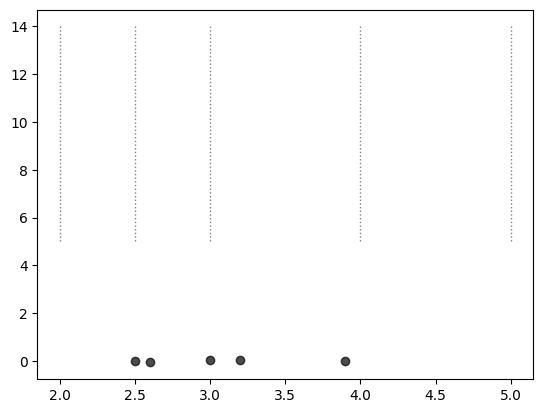

In [26]:
min_avg_diff = 1000
for i in range(esm_combos.shape[0]):
    esm_sample = esm_combos.iloc[i,:]
    sample_cs = [climate_sensitives[esm_sample.values[j]] for j in range(5)]
    avg_diff = np.sum((np.diff(np.sort(sample_cs))))

    if avg_diff < min_avg_diff:
        min_avg_diff = avg_diff
        min_sample = esm_sample
        min_sample_cs = sample_cs

plt.scatter(y=np.random.normal(0, 0.05, len(min_sample_cs)), x = min_sample_cs, color='black', alpha=0.7) 
plt.vlines(x=[2, 2.5, 3, 4, 5], ymin=5, ymax=14, colors='gray', ls=':', lw=1)

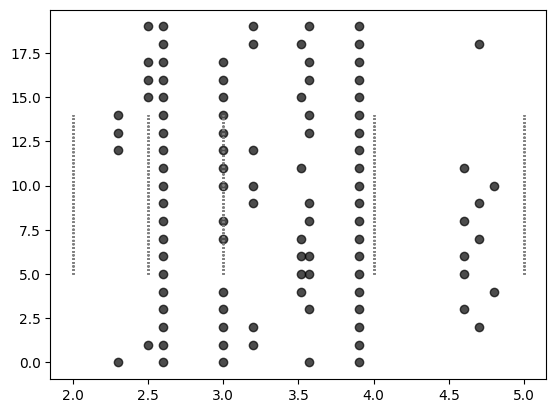

In [27]:
# for i in range(esm_combos.shape[0]):
for i in range(20):
    esm_sample = esm_combos.iloc[i,:]
    sample_cs = [climate_sensitives[esm_sample.values[j]] for j in range(5)]
    plt.scatter(y=np.random.normal(i, 0, len(sample_cs)), x = sample_cs, color='black', alpha=0.7)
    plt.vlines(x=[2, 2.5, 3, 4, 5], ymin=5, ymax=14, colors='gray', ls=':', lw=1)

In [51]:
sample_cs = [climate_sensitives[esm_sample.values[j]] for j in range(5)]
sample_cs

[3.9, 3.0, 2.6, 3.2, 2.5]

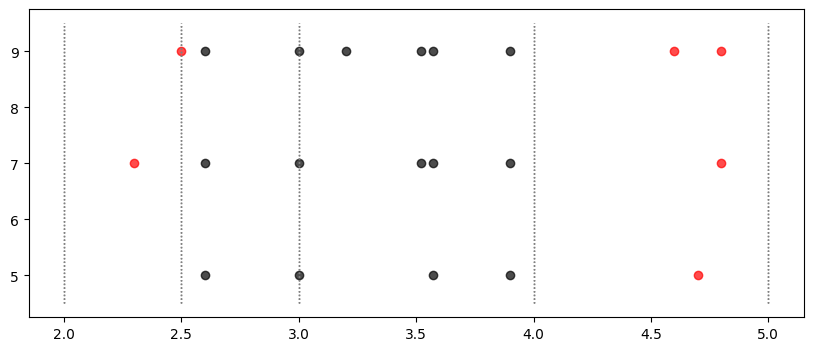

In [37]:
fig = plt.figure(figsize=(10,4))
for n in range(5, 10, 2):
    ssl, ssvl, _, _ = get_good_sample(n)
    plt.scatter(y=np.random.normal(n, 0.00, ssvl.shape[0]), x = ssvl.climate_sensitivity, color = 'red', alpha=0.7)
    plt.scatter(y=np.random.normal(n, 0.00, ssl.shape[0]), x = ssl.climate_sensitivity, color='black', alpha=0.7)
    plt.vlines(x=[2, 2.5, 3, 4, 5], ymin=4.5, ymax=9.5, colors='gray', ls=':', lw=1)

In [57]:
full_quants = climate_sensitivies_df.quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)['climate_sensitivity'].values
full_mse = np.sum(np.square(ipcc_quants - full_quants))
print(f'MSE with all criteria samples: {full_mse}')
climate_sensitivies_df.quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)

MSE with all criteria samples: 0.6654777777777781


,climate_sensitivity
0.050000,1.940000
0.166667,2.500000
0.500000,3.200000
0.833333,4.733333
0.950000,5.290000


In [58]:
all_mse = included_cs_df.quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)['climate_sensitivity'].values
all_mse = np.sum(np.square(ipcc_quants - all_mse))
print(f'MSE with all criteria samples: {all_mse}')
print(included_cs_df)
included_cs_df.quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)

MSE with all criteria samples: 2.4559999999999995
              esm  climate_sensitivity        group
0      ACCESS-CM2                  4.7  very likely
1   ACCESS-ESM1-5                  3.9       likely
3     CAMS-CSM1-0                  2.3  very likely
4           CESM2                  5.2     unlikely
5     CESM2-WACCM                  4.8  very likely
8         CanESM5                  5.6     unlikely
18      INM-CM5-0                  1.9     unlikely
20   IPSL-CM6A-LR                  4.6  very likely
22         MIROC6                  2.6       likely
23  MPI-ESM1-2-HR                  3.0       likely
24  MPI-ESM1-2-LR                  3.0       likely
25     MRI-ESM2-0                  3.2       likely
29    UKESM1-0-LL                  5.3     unlikely


,climate_sensitivity
0.050000,2.14
0.166667,2.60
0.500000,3.90
0.833333,5.20
0.950000,5.42


In [59]:
best_err_eight = 10000
best_index_eight = np.nan
for index in list(combinations(included_cs_df.index,8)):
    new_quants = included_cs_df.loc[index,:].quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)['climate_sensitivity'].values
    mse = np.sum(np.square((new_quants - ipcc_quants)))
    if mse < best_err_eight:
        best_index_eight = index
        best_err_eight = mse

best_err_five = 10000
best_index_five = np.nan
for index in list(combinations(included_cs_df.index,5)):
    new_quants = included_cs_df.loc[index,:].quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)['climate_sensitivity'].values
    mse = np.sum(np.square((new_quants - ipcc_quants)))
    if mse < best_err_five:
        best_index_five = index
        best_err_five = mse

In [60]:
print(f'MSE with 8 samples: {best_err_eight}')
print(included_cs_df.loc[best_index_eight,:])
included_cs_df.loc[best_index_eight,:].quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)

MSE with 8 samples: 0.0710694444444444
              esm  climate_sensitivity        group
1   ACCESS-ESM1-5                  3.9       likely
3     CAMS-CSM1-0                  2.3  very likely
8         CanESM5                  5.6     unlikely
18      INM-CM5-0                  1.9     unlikely
22         MIROC6                  2.6       likely
23  MPI-ESM1-2-HR                  3.0       likely
24  MPI-ESM1-2-LR                  3.0       likely
25     MRI-ESM2-0                  3.2       likely


,climate_sensitivity
0.050000,2.040000
0.166667,2.350000
0.500000,3.000000
0.833333,3.783333
0.950000,5.005000


In [61]:
print(f'MSE with 5 samples: {best_err_five}')
print(included_cs_df.loc[best_index_five,:])
included_cs_df.loc[best_index_five,:].quantile([0.05, 1/6, 0.5, 5/6, 0.95], numeric_only=True)

MSE with 5 samples: 0.03377777777777759
              esm  climate_sensitivity     group
8         CanESM5                  5.6  unlikely
18      INM-CM5-0                  1.9  unlikely
22         MIROC6                  2.6    likely
23  MPI-ESM1-2-HR                  3.0    likely
25     MRI-ESM2-0                  3.2    likely


,climate_sensitivity
0.050000,2.040000
0.166667,2.366667
0.500000,3.000000
0.833333,4.000000
0.950000,5.120000


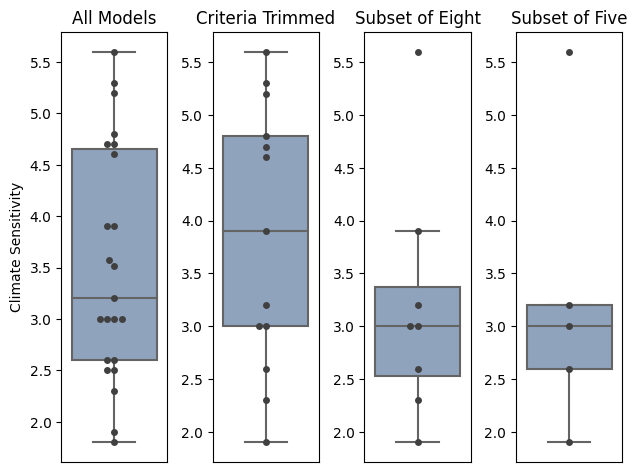

In [62]:
included_esms = inclusion_df[inclusion_df['include']]['esm'].values
included_cs_df = climate_sensitivies_df[np.isin(climate_sensitivies_df['esm'], included_esms)]
eight_cs_df = included_cs_df.loc[best_index_eight,:]
five_cs_df = included_cs_df.loc[best_index_five,:]

fig, (ax1,ax2, ax3, ax4) = plt.subplots(1,4)
sns.boxplot(ax = ax1, y='climate_sensitivity', data=climate_sensitivies_df, showfliers = False, color='#89a2c4')
sns.swarmplot(ax = ax1, y='climate_sensitivity', data=climate_sensitivies_df, color='0.25')
sns.boxplot(ax = ax2, y='climate_sensitivity', data=included_cs_df, showfliers = False, color='#89a2c4')
sns.swarmplot(ax = ax2, y='climate_sensitivity', data=included_cs_df, color='0.25')
sns.boxplot(ax = ax3, y='climate_sensitivity', data=eight_cs_df, showfliers = False, color='#89a2c4')
sns.swarmplot(ax = ax3, y='climate_sensitivity', data=eight_cs_df, color='0.25')
sns.boxplot(ax = ax4, y='climate_sensitivity', data=five_cs_df, showfliers = False, color='#89a2c4')
sns.swarmplot(ax = ax4, y='climate_sensitivity', data=five_cs_df, color='0.25')

ax1.set_title('All Models')
ax2.set_title('Criteria Trimmed')
ax3.set_title('Subset of Eight')
ax4.set_title('Subset of Five')
ax1.tick_params(axis='x', bottom=False, top=False, which='both', labelbottom=False)
ax2.tick_params(axis='x', bottom=False, top=False, which='both', labelbottom=False)
ax3.tick_params(axis='x', bottom=False, top=False, which='both', labelbottom=False)
ax4.tick_params(axis='x', bottom=False, top=False, which='both', labelbottom=False)
ax1.set_ylabel('Climate Sensitivity')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')

fig.tight_layout(pad=1.0)

In [63]:
# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[0.25, 0.75], whis_percents=[0.05,0.95]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    # ncols = len(X)
    # if labels is None:
    #     labels = itertools.repeat(None)
    # elif len(labels) != ncols:
    #     raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if labels is not None:
            stats['label'] = labels

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.quantile(x, 0.5)
        ## Altered line
        q1, q3 = np.quantile(x, (percents[0], percents[1]))
        # Whiskers
        stats['whislo'] = np.quantile(x, whis_percents[0])
        stats['whishi'] = np.quantile(x, whis_percents[1])

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])


        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

In [64]:
full_no_nan = climate_sensitivies_df['climate_sensitivity'].values[~np.isnan(climate_sensitivies_df['climate_sensitivity'].values)]

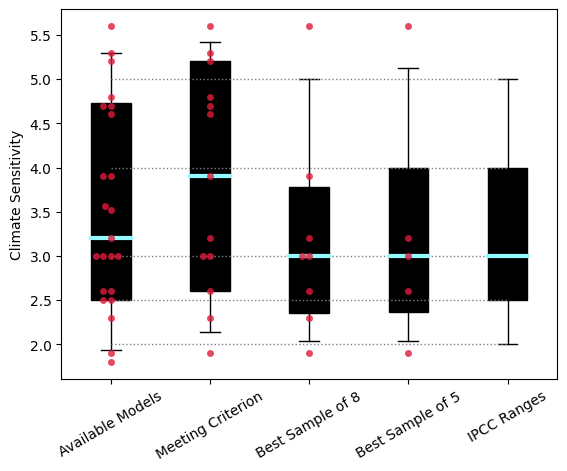

In [65]:
stats = {}
stats['E'] = my_boxplot_stats(full_no_nan, labels='Available Models', percents=[1/6, 5/6])[0]
stats['A'] = my_boxplot_stats(included_cs_df['climate_sensitivity'].values, labels='Meeting Criterion', percents=[1/6, 5/6])[0]
stats['B'] = my_boxplot_stats(eight_cs_df['climate_sensitivity'].values, labels='Best Sample of 8', percents=[1/6, 5/6])[0]
stats['C'] = my_boxplot_stats(five_cs_df['climate_sensitivity'].values, labels='Best Sample of 5', percents=[1/6, 5/6])[0]
stats['D'] = stats['C'].copy()
stats['D']['med'] = 3
stats['D']['whishi'] = 5
stats['D']['whislo'] = 2
stats['D']['q1'] = 2.5
stats['D']['q3'] = 4
stats['D']['label'] = 'IPCC Ranges'

fig, ax = plt.subplots(1, 1)

widths = 0.4
# Plot boxplots from our computed statistics
mf = ax.bxp([stats['E'], stats['A'], stats['B'], stats['C'], stats['D']], positions=np.arange(0,5), showfliers=False, widths = widths, 
            patch_artist=True, vert=True)

for patch in mf['boxes']:
    patch.set_facecolor('black')
for median in mf['medians']:
    median.set_color('#94faff')
    median.set_linewidth(3)

plt.hlines(y=[2, 2.5, 3, 4, 5], xmin=0, xmax=4, colors='gray', ls=':', lw=1)

alpha = 0.8
sns.swarmplot(ax = ax, x=1.2, y = full_no_nan, color='#de1b3b', alpha=alpha)
sns.swarmplot(ax = ax, x=2.2, y = 'climate_sensitivity', data=included_cs_df, color='#de1b3b', alpha=alpha)
sns.swarmplot(ax = ax, x=3.2, y = 'climate_sensitivity', data=eight_cs_df, color='#de1b3b', alpha=alpha)
sns.swarmplot(ax = ax, x=4.2, y = 'climate_sensitivity', data=five_cs_df, color='#de1b3b', alpha=alpha)

plt.xticks(rotation = 30)

ax.set_ylabel('Climate Sensitivity')

plt.show()

In [69]:
included_cs_df

,esm,climate_sensitivity,group
0,ACCESS-CM2,4.7,very likely
1,ACCESS-ESM1-5,3.9,likely
3,CAMS-CSM1-0,2.3,very likely
4,CESM2,5.2,unlikely
5,CESM2-WACCM,4.8,very likely
8,CanESM5,5.6,unlikely
18,INM-CM5-0,1.9,unlikely
20,IPSL-CM6A-LR,4.6,very likely
22,MIROC6,2.6,likely
23,MPI-ESM1-2-HR,3.0,likely
